In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct, inspect
from flask import Flask, jsonify

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
measurement = session.query(Measurement).first()
measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x17b586a3908>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1}

In [11]:
#covert measurement into pandas dataframe
measurement_df = pd.read_sql("SELECT * FROM Measurement", conn)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [12]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [13]:
last_date = dt.date(2017, 8 ,23)
year_ago = last_date - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores
date_precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between(year_ago, last_date)).all()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
date_precip_df = pd.DataFrame(date_precip).set_index("date")

In [16]:
# Sort the dataframe by date
date_precip_df = date_precip_df.sort_values("date")

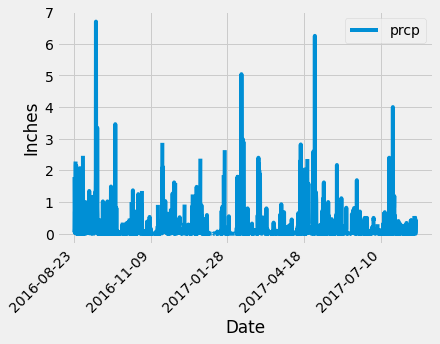

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
date_precip_df.plot(y = "prcp")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation = "45", horizontalalignment = "right")
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(distinct(Measurement.station)).count()
station_count

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
print(f"The most active station is {active_stations[0][0]}.")

The most active station is USC00519281.


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
print(f"The lowest temperature is {lowest_temp}, the highest temperature is {highest_temp}, and the average temperature is {avg_temp}.")

The lowest temperature is 54.0, the highest temperature is 85.0, and the average temperature is 71.66378066378067.


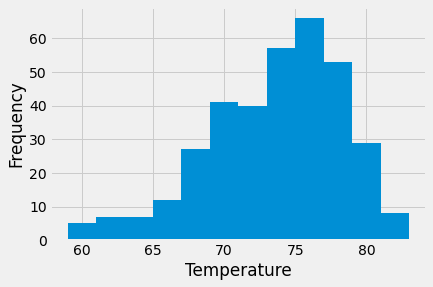

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_high_temp = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date.between(year_ago, last_date)).all()
station_high_temp_df = pd.DataFrame(station_high_temp).set_index("date")
plt.hist(station_high_temp_df["tobs"], bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()